## Train data import and processing

In [ ]:
import os, gc
import datetime

import numpy as np
import pandas as pd

import category_encoders

from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from lightgbm import LGBMRegressor

from mlxtend.regressor import StackingRegressor

from pandas.api.types import is_categorical_dtype
from pandas.api.types import is_datetime64_any_dtype as is_datetime

In [ ]:
# Memory optimization

# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16
def reduce_mem_usage(data, use_float16=False) -> pd.DataFrame:
    start_mem = data.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in data.columns:
        if is_datetime(data[col]) or is_categorical_dtype(data[col]):
            continue
        col_type = data[col].dtype

        if col_type != object:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)
        else:
            data[col] = data[col].astype('category')

    end_mem = data.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.2f}%'.format(
        100 * (start_mem - end_mem) / start_mem))

    return data

In [ ]:
# Path to data 
PATH = '../input/ashrae-energy-prediction/'

In [ ]:
# Import train data
train = pd.read_csv(f'{PATH}train.csv')
weather_train = pd.read_csv(f'{PATH}weather_train.csv')

# Import metadata
metadata = pd.read_csv(f'{PATH}building_metadata.csv')

In [ ]:
# Remove outliers in train data
train = train[train['building_id'] != 1099]
train = train.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

In [ ]:
# Function for weather data processing
#https://www.kaggle.com/aitude/ashrae-missing-weather-data-handling
def weather_data_parser(weather_data) -> pd.DataFrame:
    time_format = '%Y-%m-%d %H:%M:%S'
    start_date = datetime.datetime.strptime(weather_data['timestamp'].min(), time_format)
    end_date = datetime.datetime.strptime(weather_data['timestamp'].max(), time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

    for site_id in range(16):
        site_hours = np.array(weather_data[weather_data['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list, site_hours), columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather_data = pd.concat([weather_data, new_rows], sort=True)
        weather_data = weather_data.reset_index(drop=True)           

    weather_data['datetime'] = pd.to_datetime(weather_data['timestamp'])
    weather_data['day'] = weather_data['datetime'].dt.day
    weather_data['week'] = weather_data['datetime'].dt.week
    weather_data['month'] = weather_data['datetime'].dt.month

    weather_data = weather_data.set_index(['site_id', 'day', 'month'])

    air_temperature_filler = pd.DataFrame(weather_data.groupby(['site_id','day','month'])['air_temperature'].median(), columns=['air_temperature'])
    weather_data.update(air_temperature_filler, overwrite=False)

    cloud_coverage_filler = weather_data.groupby(['site_id', 'day', 'month'])['cloud_coverage'].median()
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'), columns=['cloud_coverage'])

    weather_data.update(cloud_coverage_filler, overwrite=False)

    due_temperature_filler = pd.DataFrame(weather_data.groupby(['site_id','day','month'])['dew_temperature'].median(), columns=['dew_temperature'])
    weather_data.update(due_temperature_filler, overwrite=False)

    sea_level_filler = weather_data.groupby(['site_id','day','month'])['sea_level_pressure'].median()
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'), columns=['sea_level_pressure'])

    weather_data.update(sea_level_filler, overwrite=False)

    wind_direction_filler =  pd.DataFrame(weather_data.groupby(['site_id','day','month'])['wind_direction'].median(), columns=['wind_direction'])
    weather_data.update(wind_direction_filler, overwrite=False)

    wind_speed_filler =  pd.DataFrame(weather_data.groupby(['site_id','day','month'])['wind_speed'].median(), columns=['wind_speed'])
    weather_data.update(wind_speed_filler, overwrite=False)

    precip_depth_filler = weather_data.groupby(['site_id','day','month'])['precip_depth_1_hr'].median()
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'), columns=['precip_depth_1_hr'])

    weather_data.update(precip_depth_filler, overwrite=False)

    weather_data = weather_data.reset_index()
    weather_data = weather_data.drop(['datetime','day','week','month'], axis=1)

    return weather_data

In [ ]:
# Train weather data processing
weather_train = weather_data_parser(weather_train)

In [ ]:
# Memory optimization
train = reduce_mem_usage(train, use_float16=True)
weather_train = reduce_mem_usage(weather_train, use_float16=True)
metadata = reduce_mem_usage(metadata, use_float16=True)

Memory usage of dataframe is 757.31 MB
Memory usage after optimization is: 322.24 MB
Decreased by 57.45%
Memory usage of dataframe is 9.65 MB
Memory usage after optimization is: 2.66 MB
Decreased by 72.46%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 73.76%


In [ ]:
# Merge train data 
train = train.merge(metadata, on='building_id', how='left')
train = train.merge(weather_train, on=['site_id', 'timestamp'], how='left')

del weather_train; gc.collect()

0

In [ ]:
# Function for train and test data processing
def data_parser(data) -> pd.DataFrame:
    data.sort_values('timestamp')
    data.reset_index(drop=True)
    
    data['timestamp'] = pd.to_datetime(data['timestamp'], format='%Y-%m-%d %H:%M:%S')
    data['weekday'] = data['timestamp'].dt.weekday
    data['hour'] = data['timestamp'].dt.hour
    
    data['square_feet'] =  np.log1p(data['square_feet']) 
    
    data = data.drop(['timestamp', 'sea_level_pressure',
        'wind_direction', 'wind_speed', 'year_built', 'floor_count'], axis=1)
    
    gc.collect()
    
    encoder = LabelEncoder()
    data['primary_use'] = encoder.fit_transform(data['primary_use'])
    
    return data

In [ ]:
# Train data processing
train = data_parser(train)

In [ ]:
# Define target and predictors
target = np.log1p(train['meter_reading'])
features = train.drop(['meter_reading'], axis = 1) 

del train; gc.collect()

0

In [ ]:
# Process categorical features
categorical_features = ['building_id', 'site_id', 'meter', 'primary_use']

encoder = category_encoders.CountEncoder(cols=categorical_features)
encoder.fit(features)
features = encoder.transform(features)

features_size = features.shape[0]
for feature in categorical_features:
    features[feature] = features[feature] / features_size

In [ ]:
# Missing data imputation
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer.fit(features)
features = imputer.transform(features)

## Model training 

As a simple example we will create meta-regressor by stacking together regularized Ridge and Lasso regression models with LightGBM regressor. In this example there is minimum hyperparameters tuning and just three regressors are stacked together for simplicity.

In [ ]:
# Regressors
#http://rasbt.github.io/mlxtend/user_guide/regressor/StackingRegressor/
lightgbm = LGBMRegressor(objective='regression', learning_rate=0.05, num_leaves=1024,
    feature_fraction=0.8, bagging_fraction=0.9, bagging_freq=5) 

ridge = Ridge(alpha=0.3)
lasso = Lasso(alpha=0.3)

In [ ]:
kfold = KFold(n_splits=2, shuffle=False)

models = []

for idx, (train_idx, val_idx) in enumerate(kfold.split(features)):
    
    train_features, train_target = features[train_idx], target[train_idx]
    val_features, val_target = features[val_idx], target[val_idx]
    
    model = StackingRegressor(regressors=(lightgbm, ridge, lasso),
        meta_regressor=lightgbm, use_features_in_secondary=True)

    model.fit(np.array(train_features), np.array(train_target))
    import pickle
    import joblib
    filename_reg='stacked_reg.sav'
    joblib.dump(model,filename_reg)
    models.append(model)

    print('RMSE: {:.4f} of fold: {}'.format(
        np.sqrt(mean_squared_error(val_target, model.predict(np.array(val_features)))), idx))

    del train_features, train_target, val_features, val_target; gc.collect()

del features, target; gc.collect()

RMSE: 1.1669 of fold: 0
RMSE: 1.1831 of fold: 1


0

In [ ]:
import pickle
import joblib
filename_reg='stacked_reg.sav'
joblib.dump(model,filename_reg)

['stacked_reg.sav']

## Test data import and processing

In [ ]:
# Import test data
test = pd.read_csv(f'{PATH}test.csv')
weather_test = pd.read_csv(f'{PATH}weather_test.csv')

In [ ]:
row_ids = test['row_id']
test.drop('row_id', axis=1, inplace=True)

In [ ]:
# Test weather data processing
weather_test = weather_data_parser(weather_test)

In [ ]:
# Memory optimization
test = reduce_mem_usage(test, use_float16=True)
weather_test = reduce_mem_usage(weather_test, use_float16=True)

Memory usage of dataframe is 954.38 MB
Memory usage after optimization is: 199.59 MB
Decreased by 79.09%
Memory usage of dataframe is 19.25 MB
Memory usage after optimization is: 5.30 MB
Decreased by 72.45%


In [ ]:
# Merge test data
test = test.merge(metadata, on='building_id', how='left')
test = test.merge(weather_test, on=['site_id', 'timestamp'], how='left')

del metadata; gc.collect()

0

In [ ]:
# Test data processing
test = data_parser(test)

test = encoder.transform(test)
for feature in categorical_features:
    test[feature] = test[feature] / features_size

test = imputer.transform(test)

## Make predictions and create submission file

In [ ]:
# Make predictions
predictions = 0
for model in models:
    predictions += np.expm1(model.predict(np.array(test))) / len(models)
    del model; gc.collect()

del test, models; gc.collect()

0

In [ ]:
# Create submission file
submission = pd.DataFrame({
    'row_id': row_ids,
    'meter_reading': np.clip(predictions, 0, a_max=None)
})
submission.to_csv('stacked_regression_submission.csv', index=False, float_format='%.4f')

In [ ]:
from prettytable import PrettyTable
summary = PrettyTable()


summary.field_names = ["Model","RMSE","Fold"]
summary.add_row(["Stacked Regression",1.16, 0])
summary.add_row(["Stacked Regression",1.18, 1])
print(summary)

+--------------------+------+------+
|       Model        | RMSE | Fold |
+--------------------+------+------+
| Stacked Regression | 1.16 |  0   |
| Stacked Regression | 1.18 |  1   |
+--------------------+------+------+


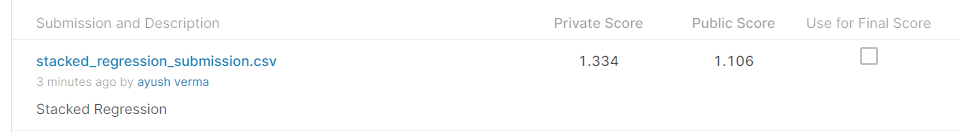

In [ ]:
from IPython.display import Image
Image(filename='stacked_regressor2.PNG')

Summary
1. I impute weather data with mean and median
2. I imput the the remaining missing values with SimpleImputer with median
3. Very basic FE because of the ram problem and also i seen in the lightgb gbdt that raw features are the most important fetaures 
4. Remove outlier
5. Do standardisation on train and test
6. This file run on kaggle notebook please don't try to run on the google colab because of the limited ram


Refrences
1. http://rasbt.github.io/mlxtend/user_guide/regressor/StackingRegressor/
2. https://www.kaggle.com/aitude/ashrae-missing-weather-data-handling
3. https://contrib.scikit-learn.org/category_encoders/count.html